In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.metrics import Accuracy, Precision, Recall

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import albumentations as A

In [2]:
MNIST_1 = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

MNIST_2 = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [3]:
class Noisy(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None):

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.dataset = dataset.data[start:end] / 255

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = (self.dataset[idx] + torch.rand(28, 28) * 0.7 ).unsqueeze(0)
        target = self.dataset[idx].unsqueeze(0)
            
        return data, target

In [4]:
NOISY_train_dataset = Noisy(MNIST_1, 'train')
NOISY_val_dataset = Noisy(MNIST_1, 'val')
NOISY_test_dataset = Noisy(MNIST_2, 'test')

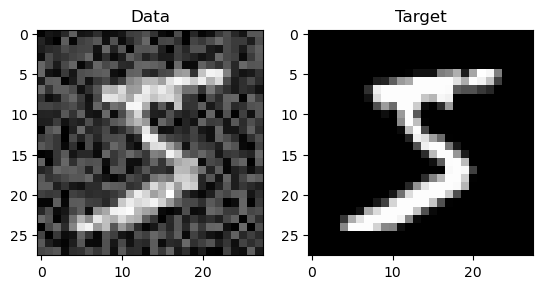

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(NOISY_train_dataset[0][0].squeeze(), cmap='gray')
axs[1].imshow(NOISY_train_dataset[0][1].squeeze(), cmap='gray')

axs[0].title.set_text('Data')
axs[1].title.set_text('Target')

plt.show()

In [6]:
denoiser = nn.Sequential(
    # encode
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    # decode
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 1, kernel_size=3, padding=1),
    nn.ReLU(),
)

In [7]:
%%capture

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

denoiser.to(device)

In [8]:
def train_model(model, batch_size, learning_rate, num_epochs, train_dataset, val_dataset,
               criterion, optimizer, scheduler, output_filename):
    
    # do not compute accuracy for regression problems
    classification = criterion == torch.nn.CrossEntropyLoss
    
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    scheduler = scheduler(optimizer)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    total_progress = tqdm(total=num_epochs, desc='Total progress')
    epoch_losses = []
    
    if classification:
        epoch_accuracies = []
        accuracy = Accuracy()

    for epoch in range(num_epochs):
        model.train()
        epoch_progress = tqdm(total=len(train_loader), desc=f'Training epoch #{epoch}...', leave=False)
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_progress.update()
        epoch_progress.close()

        model.eval()
        val_progress = tqdm(total=len(val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
        val_losses = []
        
        if classification:
            accuracy.reset()
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_losses.append(loss.item())
            val_progress.update()
            if classification:
                accuracy.update((output, target))
        val_progress.close()

        mean_val_loss = np.mean(val_losses)
        epoch_losses.append(mean_val_loss)
        if classification:
            current_accuracy = accuracy.compute()
            epoch_accuracies.append(current_accuracy)
            if current_accuracy == max(epoch_accuracies):
                torch.save(model, output_filename)
        else:
            if mean_val_loss == min(epoch_losses):
                torch.save(model, output_filename)            
        
        if scheduler:
            scheduler.step(mean_val_loss)

        print(f"Val loss #{epoch}: {np.mean(val_losses)}")
        if classification:
            print(f"Val accuracy #{epoch}: {current_accuracy}")

        total_progress.update()

    total_progress.close()

In [9]:
train_model(model=denoiser,
            batch_size=256,
            learning_rate=0.01,
            num_epochs=30,
            train_dataset=NOISY_train_dataset,
            val_dataset=NOISY_val_dataset,
            criterion=torch.nn.MSELoss,
            optimizer=optim.SGD,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            output_filename='denoiser_least_loss.pt'
           )

Total progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch #0...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #0...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #0: 0.01494487100359747


Training epoch #1...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #1...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #1: 0.0103785898694295


Training epoch #2...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #2...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #2: 0.008842911176636057


Training epoch #3...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #3...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #3: 0.007864304912923756


Training epoch #4...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #4...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #4: 0.007274606517689713


Training epoch #5...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #5...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #5: 0.0068846561598702


Training epoch #6...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #6...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #6: 0.006610189169897872


Training epoch #7...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #7...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #7: 0.0063191344803672726


Training epoch #8...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #8...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #8: 0.006117367201437384


Training epoch #9...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #9...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #9: 0.005962339364055355


Training epoch #10...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #10...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #10: 0.005903328982008211


Training epoch #11...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #11...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #11: 0.005627801152482881


Training epoch #12...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #12...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #12: 0.005574882693462453


Training epoch #13...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #13...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #13: 0.005475261382821758


Training epoch #14...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #14...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #14: 0.005325444492558807


Training epoch #15...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #15...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #15: 0.005222983942446062


Training epoch #16...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #16...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #16: 0.005160915531154911


Training epoch #17...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #17...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #17: 0.005144847399097378


Training epoch #18...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #18...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #18: 0.005197237608796459


Training epoch #19...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #19...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #19: 0.004957521642100508


Training epoch #20...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #20...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #20: 0.004889935578645791


Training epoch #21...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #21...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #21: 0.004846283092589701


Training epoch #22...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #22...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #22: 0.004870507708292896


Training epoch #23...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #23...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #23: 0.004752075465364477


Training epoch #24...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #24...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #24: 0.004738291622912985


Training epoch #25...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #25...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #25: 0.004661947591388125


Training epoch #26...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #26...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #26: 0.0047306067989034166


Training epoch #27...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #27...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #27: 0.004602805537692571


Training epoch #28...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #28...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #28: 0.004597789244884152


Training epoch #29...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #29...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #29: 0.00459076121638892


In [10]:
def denoise(img, denoiser, device):
    
    denoiser.to(device).eval()
    data = img.reshape(-1, 1, 28, 28).to(device)
    denoised = denoiser(data).squeeze()
    
    return denoised

In [11]:
%%capture
best_denoiser = torch.load('denoiser_least_loss.pt')
best_denoiser.eval()

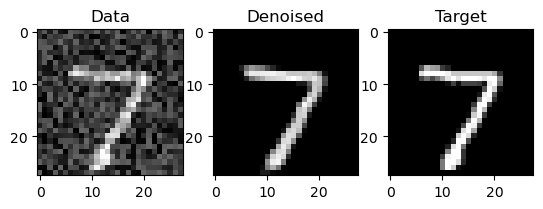

In [12]:

output = denoise(NOISY_test_dataset[0][0], denoiser=best_denoiser, device='cuda')

fig, axs = plt.subplots(1, 3)

axs[0].imshow(NOISY_test_dataset[0][0].squeeze(), cmap='gray')
axs[1].imshow(output.cpu().detach().numpy().squeeze(), cmap='gray')
axs[2].imshow(NOISY_test_dataset[0][1].squeeze(), cmap='gray')

axs[0].title.set_text('Data')
axs[1].title.set_text('Denoised')
axs[2].title.set_text('Target')

plt.show()

**Training a classifier (for the denoiser  evaluation)**

In [13]:
class MNIST(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None, augment=False, normalize=False):
        
        if augment:
            self.transform = A.Compose([
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=1.0)
            ])      
        
        self.augment = augment
        self.normalize = normalize

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.data = dataset.data[start:end] / 255
        self.targets = dataset.targets[start:end]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.data[idx]
        target = self.targets[idx]
        
        if self.augment:
            data = torch.tensor(self.transform(image=data.numpy())['image'])
        
        if self.normalize:
            data = (data - data.mean()) / data.std()
            
        return data.unsqueeze(0), target

In [14]:
MNIST_train_dataset = MNIST(MNIST_1, 'train', True, True)
MNIST_val_dataset = MNIST(MNIST_1, 'val', True, True)
MNIST_test_dataset = MNIST(MNIST_2, 'test', False, False)

In [15]:
classifier = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(7*7*64, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)

In [16]:
%%capture
classifier.to(device)

In [18]:
train_model(model=classifier,
            batch_size=256,
            learning_rate=0.1,
            num_epochs=30,
            train_dataset=MNIST_train_dataset,
            val_dataset=MNIST_val_dataset,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=optim.SGD,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            output_filename='classifier_best_accuracy.pt' 
           )

Total progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch #0...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #0...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #0: 0.3511305294804654
Val accuracy #0: 0.8937333333333334


Training epoch #1...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #1...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #1: 0.1325774320985301
Val accuracy #1: 0.9585333333333333


Training epoch #2...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #2...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #2: 0.08003324633306366
Val accuracy #2: 0.9743333333333334


Training epoch #3...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #3...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #3: 0.070297778331501
Val accuracy #3: 0.9777333333333333


Training epoch #4...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #4...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #4: 0.08405695789319984
Val accuracy #4: 0.9741333333333333


Training epoch #5...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #5...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #5: 0.060354308461991406
Val accuracy #5: 0.9812


Training epoch #6...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #6...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #6: 0.08172860605863191
Val accuracy #6: 0.9746666666666667


Training epoch #7...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #7...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #7: 0.050651877234547824
Val accuracy #7: 0.9841333333333333


Training epoch #8...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #8...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #8: 0.052520474742592894
Val accuracy #8: 0.9835333333333334


Training epoch #9...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #9...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #9: 0.04718157923701456
Val accuracy #9: 0.9856


Training epoch #10...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #10...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #10: 0.049121678051128354
Val accuracy #10: 0.9851333333333333


Training epoch #11...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #11...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #11: 0.04665182859210645
Val accuracy #11: 0.9862


Training epoch #12...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #12...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #12: 0.04222710110183995
Val accuracy #12: 0.9879333333333333


Training epoch #13...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #13...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #13: 0.04978055745694723
Val accuracy #13: 0.985


Training epoch #14...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #14...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #14: 0.0410510094804784
Val accuracy #14: 0.9878


Training epoch #15...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #15...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #15: 0.04375847271580439
Val accuracy #15: 0.9869333333333333


Training epoch #16...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #16...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #16: 0.04855423076157221
Val accuracy #16: 0.9858666666666667


Training epoch #17...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #17...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #17: 0.037972710300552645
Val accuracy #17: 0.9887333333333334


Training epoch #18...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #18...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #18: 0.04006866917756023
Val accuracy #18: 0.9884666666666667


Training epoch #19...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #19...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #19: 0.04039169754339698
Val accuracy #19: 0.9891333333333333


Training epoch #20...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #20...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #20: 0.03529825932898764
Val accuracy #20: 0.9891333333333333


Training epoch #21...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #21...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #21: 0.03903160145174775
Val accuracy #21: 0.9885333333333334


Training epoch #22...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #22...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #22: 0.03759625815328652
Val accuracy #22: 0.989


Training epoch #23...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #23...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #23: 0.038257302653233884
Val accuracy #23: 0.9893333333333333


Training epoch #24...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #24...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #24: 0.03656978707097597
Val accuracy #24: 0.9894


Training epoch #25...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #25...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #25: 0.03713479685455055
Val accuracy #25: 0.9894666666666667


Training epoch #26...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #26...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #26: 0.03316018442619371
Val accuracy #26: 0.9913333333333333


Training epoch #27...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #27...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #27: 0.04327083403497177
Val accuracy #27: 0.9884666666666667


Training epoch #28...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #28...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #28: 0.03789279716764182
Val accuracy #28: 0.989


Training epoch #29...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #29...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #29: 0.04016119417077388
Val accuracy #29: 0.9883333333333333


**Evaluation**

In [23]:
%%capture

best_classifier = torch.load('clasifier_best_accuracy.pt' )

best_denoiser.to(device).eval()
best_classifier.to(device).eval()

In [24]:
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=256, shuffle=False)
accuracy = Accuracy()
precision = Precision()
recall = Recall()

In [25]:
def evaluate(classifier, data_loader, accuracy, precision, recall, add_noise=False, denoiser=None):
    
    accuracy.reset()
    precision.reset()
    recall.reset()
    
    classifier.eval()
    if denoiser:
        denoiser.eval()
        
    for data, target in data_loader:
        
            data = data.to(device)
            
            if add_noise:
                noise = torch.rand(len(data), 1, 28, 28) * .7
                data += noise.to(device)

            if denoiser:
                data = denoise(data, denoiser=denoiser, device=device)
                data = data.reshape(-1, 1, 28, 28)
                
            # standardization
            data = (data - data.mean()) / data.std()
    
            target = target.to(device)
            output = best_classifier(data)
            accuracy.update((output, target))
            precision.update((output, target))
            recall.update((output, target))
    
    if not add_noise and not denoiser:
        label = 'Clean accuracy'
    elif add_noise and not denoiser:
        label = 'Noisy accuracy'
    elif add_noise and denoiser:
        label = 'Denoised accuracy'
    else:
        label = 'Accuracy'

    print(f'{label}: {accuracy.compute()}')
#     print(f'Test precision: {precision.compute().mean()}')
#     print(f'Test precision: {recall.compute().mean()}')


In [26]:
evaluate(best_classifier, MNIST_test_loader, accuracy, precision, recall, add_noise=False, denoiser=None)
evaluate(best_classifier, MNIST_test_loader, accuracy, precision, recall, add_noise=True, denoiser=None)
evaluate(best_classifier, MNIST_test_loader, accuracy, precision, recall, add_noise=True, denoiser=best_denoiser)

Clean accuracy: 0.9935
Noisy accuracy: 0.9904
Denoised accuracy: 0.9891
